# Scrape Results of all UFC Fights

In [ ]:
from bs4 import BeautifulSoup
import requests
import pickle
import os

# include all paths to data from local storage location
PATH_TO_UFC_FIGHT_RESULTS = os.environ['DATAFILES_PATH'] + '/UFC_Results_Modeling/' + 'fight_results.pkl'
PATH_TO_UFC_FIGHT_PRED_DATA = os.environ['DATAFILES_PATH'] + '/UFC_Results_Modeling/' + 'fight_data.csv'


In [ ]:
fight_res = {}

url = requests.get("http://ufcstats.com/statistics/events/completed?page=all")
html = url.text

soup = BeautifulSoup(html)

for i, a in enumerate(soup.find_all('a', href=True)):
    
    if i in set(range(60, 636)):
        print("Reading UFC Event:", a['href'])
        ev_url = requests.get(a['href'])
        ev_html = ev_url.text
        ev_soup = BeautifulSoup(ev_html)
        tr = ev_soup.find_all('tr', attrs={'class': 'b-fight-details__table-row b-fight-details__table-row__hover js-fight-details-click'})
        
        for el in tr:
            p = el.find_all("p", attrs={'class': 'b-fight-details__table-text'})
            if p is not None:
                print("Fighter #1:", p[1].get_text().strip())
                print("Fighter #2:", p[2].get_text().strip())
                print("Win by:", p[12].get_text().strip())
                
                f1 = p[1].get_text().strip().lower().replace(' ', '_')
                f2 = p[2].get_text().strip().lower().replace(' ', '_')
                w_method = p[12].get_text().strip()

                fight_res[min(f1, f2) + '_'+ max(f1, f2)] = w_method
            
        

        
# Write out results to file
with open(PATH_TO_UFC_FIGHT_RESULTS, 'wb') as f:
    pickle.dump(fight_res, f)

# Or load in the data

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os

# include all paths to data from local storage location
PATH_TO_UFC_FIGHT_RESULTS = os.environ['DATAFILES_PATH'] + '/UFC_Results_Modeling/' + 'fight_results.pkl'
PATH_TO_UFC_FIGHT_PRED_DATA = os.environ['DATAFILES_PATH'] + '/UFC_Results_Modeling/' + 'fight_data.csv'

# Load in results from file
with open(PATH_TO_UFC_FIGHT_RESULTS, 'rb') as f:
    fight_res = pickle.load(f)

# Fill in the UFC data with missing KO/TKO information

In [4]:
ufc_df = pd.read_csv(PATH_TO_UFC_FIGHT_PRED_DATA)
fighters = ufc_df[['R_fighter', 'B_fighter']]

app_results = []
skipped_count = 0

for i in range(len(fighters)):
    print(fighters.iloc[i, 0], 'vs', fighters.iloc[i, 1])
    f1 = fighters.iloc[i, 0].strip().lower().replace(' ', '_')
    f2 = fighters.iloc[i, 1].strip().lower().replace(' ', '_')
    try:
        result = fight_res[min(f1, f2) + '_'+ max(f1, f2)]
        app_results.append(result)
    except KeyError:
        print('Skipped')
        app_results.append('Unknown')
        skipped_count += 1

ufc_df['results'] = pd.Index(app_results)

# remove NaNs
ufc_df = ufc_df.dropna()

In [3]:
ufc_data = ufc_df.loc[:, 'title_bout':'R_age']
del ufc_data['B_Weight_lbs'], ufc_data['R_Weight_lbs']

X = pd.get_dummies(ufc_data).to_numpy()
Y = pd.get_dummies(ufc_df['results'] == 'KO/TKO').to_numpy()

print('X Shape:', X.shape, '| Y Shape:', Y.shape)
print('Percentage of postives:', 100 * sum(Y[:, 1]) / Y.shape[0], '%')

X Shape: (3890, 154) | Y Shape: (3890, 2)
Percentage of postives: 32.2879177377892 %


# Multilayer Neural Net Model with Regularization

Using the Multilayer Neural Net Alone resulted in a poor test error. I will attempt to use weight decay regulariazation to provide a way to not use all weights in the neural net construction. We start with large number of Nodes per layer (like 100) since regularization will 'shrink' those that are unnecessary.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.layers import Dense
from keras.models import Sequential
from keras.backend import clear_session # for memory management 
from sklearn.metrics import confusion_matrix
from keras import regularizers # to provide weight decay

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21, stratify=Y)
n_rows, n_cols = X.shape

Using TensorFlow backend.


In [5]:
def create_model(lmda, n_lyrs):
    
    clear_session()
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape = (n_cols,),
                                      kernel_regularizer=regularizers.l2(lmda),
                                      bias_regularizer=regularizers.l2(lmda),
                                      activity_regularizer=regularizers.l2(lmda)))

    for i in range(n_lyrs):
        model.add(Dense(100, activation='relu',
                     kernel_regularizer=regularizers.l2(lmda),
                     bias_regularizer=regularizers.l2(lmda),
                     activity_regularizer=regularizers.l2(lmda)))
    
    model.add(Dense(2, activation='softmax'))
    return model

Hyper-Parameter Tuning is done here on the number of hidden layers in out NNet and the regularization paramters. We perform and grid search, and use 5-fold CV to estimate the test error for each pair of hyper-parameters. 

In [6]:
perform_grid_search = False

if perform_grid_search:

    lmda = 10.0**(-1*np.arange(3, 10)) # regularization hyper params
    n_lyrs = np.arange(2, 4) # number of hidden layers

    kf = KFold(n_splits=5)
    kf.get_n_splits(X)

    # init grid search results matrix
    test_acc = np.zeros((len(lmda), len(n_lyrs)))

    # perform grid search
    for i in range(len(lmda)):
        for j in range(len(n_lyrs)):

            folds_acc = []

            for train_index, val_index in kf.split(X):

                X_train, X_val = X[train_index], X[val_index]
                Y_train, Y_val = Y[train_index], Y[val_index]

                model = create_model(lmda[i], n_lyrs[j])
                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                model.fit(X_train, Y_train, epochs=50, verbose=0)

                # get test accuracy for this fold
                predictions = model.predict(X_val)
                Y_p = np.argmax(predictions, axis=1)
                Y_t = Y_val[:, 1]
                folds_acc.append(np.sum(Y_p == Y_t) / len(Y_p))

                del model


            test_acc[i, j] = np.mean(folds_acc)
            print('5-Fold CV Est. Test Accuracy with lambda =', lmda[i], 'and', n_lyrs[j], ' hidden layers:', test_acc[i, j])

    print(test_acc)



In [6]:
# seems like lambda = 1e-9 and 3 hidden layers provide the best estimated test error
lmda = 1e-9
n_lyrs = 3

model = create_model(lmda, n_lyrs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X, Y, epochs=100, verbose=1)

In [8]:
predictions = model.predict(X_test)
Y_p = np.argmax(predictions, axis=1)
Y_t = Y_test[:, 1]
test_acc = np.sum(Y_p == Y_t) / len(Y_p)
print('Reported Test Accuracy:', test_acc)

Reported Test Accuracy: 0.6182519280205655


Not great accuracy, but we also want to look at other metrics that may be more informative for us. For example, precision may be more important/useful to us if we are are placing bets on a KO/tKO.

# ROC Curve and Precision/Recall Curves 

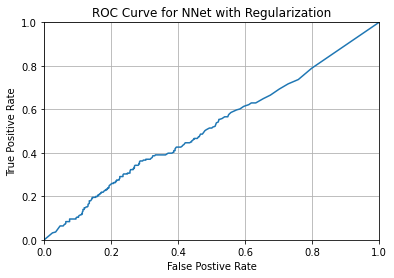

In [9]:
thresh = np.linspace(0, 1, 500)
tpr = []
fpr = []

for i in thresh:
    
    Y_p = (predictions[:, 1] > i).astype(int)
    tn, fp, fn, tp = confusion_matrix(Y_t, Y_p).ravel()
    tpr.append(tp/(tp+fn))
    fpr.append(fp/(fp+tn))
    
    
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for NNet with Regularization')
plt.grid(True)
plt.show()

/Users/andrewmashhadi/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


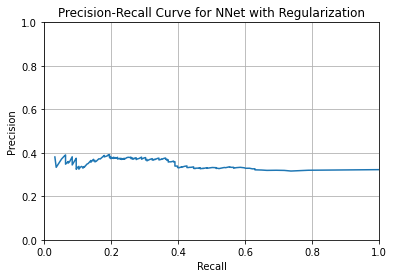

In [10]:
thresh = np.linspace(0, 1, 500)
recall = []
prec = []

for i in thresh:
    
    Y_p = (predictions[:, 1] > i).astype(int)
    tn, fp, fn, tp = confusion_matrix(Y_t, Y_p).ravel()
    recall.append(tp/(tp+fn))
    prec.append(tp/(tp+fp))
    
    
plt.plot(recall, prec)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for NNet with Regularization')
plt.grid(True)
plt.show()

Not looking good...

Things to add: 

* Try Feature Selection with Random Forest (with tuning and metrics in scikit-leanrn) or PCA. 
* Ex: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
* and https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
* Bagging (incase the random starting configurations change the minima, averaging may help).
* Try other models if preprocessing doesn't help results.
* More ROC curves and matrices, precision recall curves, and F1 scores. 